# CNN model to recognize handwritten digits

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist

from tensorflow.keras import models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Load dataset

In [2]:
def load_dataset():
    """
    Load the MNIST dataset and split it into training, validation, and test sets.

    Returns:
        Training data: Tuple of numpy arrays (train_images, train_labels).
        Validation data: Tuple of numpy arrays (val_images, val_labels).
        Test data: Tuple of numpy arrays (test_images, test_labels).
    """
     
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    # Split test data into validation and test data
    val_images = test_images[:5000]
    val_labels = test_labels[:5000]
    test_images = test_images[5000:]
    test_labels = test_labels[5000:]

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)


In [3]:
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_dataset()

## Explore dataset

In [4]:
print("Training images shape:", train_images.shape)
print("Validation images shape:", val_images.shape)
print("Testing images shape:", test_images.shape)

Training images shape: (60000, 28, 28)
Validation images shape: (5000, 28, 28)
Testing images shape: (5000, 28, 28)


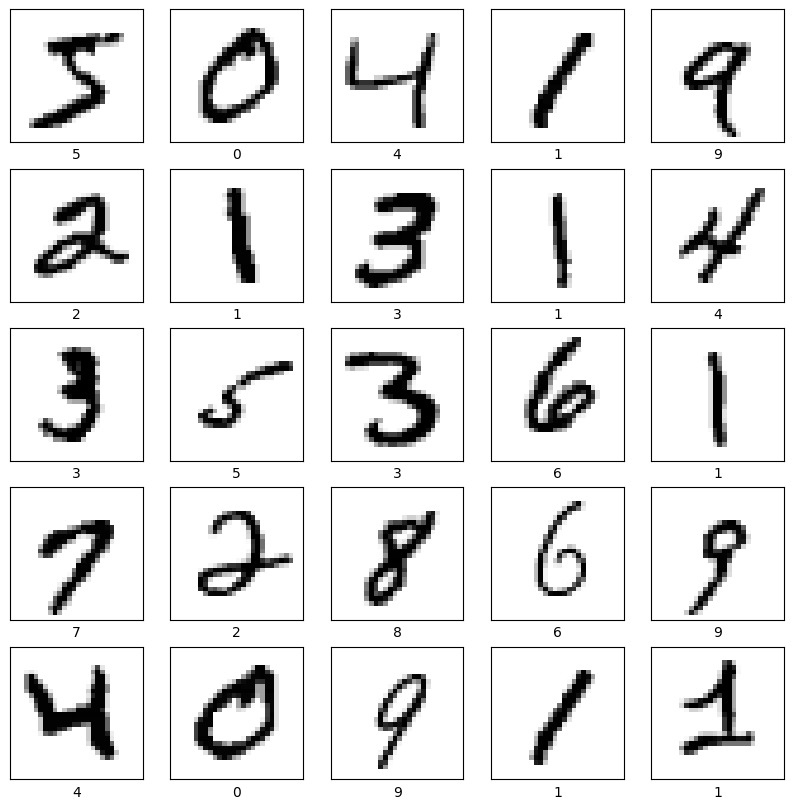

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

## Data pre-processing

As we can see, the vaules of the pixels (for example in row 21 of the first image in the train dataset) range from 0 to 255. Let's scale these values ​​in a range of 0 to 1.

In [6]:
train_images[0][21]

array([  0,   0,   0,   0,   0,   0,   0,   0,  23,  66, 213, 253, 253,
       253, 253, 198,  81,   2,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=uint8)

In [7]:
def normalize_images(train_images, val_images, test_images):
    """
    Normalize the pixel values of the images by dividing each pixel value by 255.0.

    Args:
        train_images (numpy.ndarray): Training images dataset.
        val_images (numpy.ndarray): Validation images dataset.
        test_images (numpy.ndarray): Test images dataset.

    Returns:
        norm_train_images (numpy.ndarray): Normalized training images dataset.
        norm_val_images (numpy.ndarray): Normalized validation images dataset.
        norm_test_images (numpy.ndarray): Normalized test images dataset.
    """
    norm_train_images = train_images / 255.0
    norm_val_images = val_images / 255.0
    norm_test_images = test_images / 255.0

    return norm_train_images, norm_val_images, norm_test_images

In [8]:
norm_train_images, norm_val_images, norm_test_images = normalize_images(train_images, val_images, test_images)

In [9]:
norm_train_images[0][21]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.09019608, 0.25882353,
       0.83529412, 0.99215686, 0.99215686, 0.99215686, 0.99215686,
       0.77647059, 0.31764706, 0.00784314, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

## Build Model

Convolutional Neural Network (CNN) architecture:

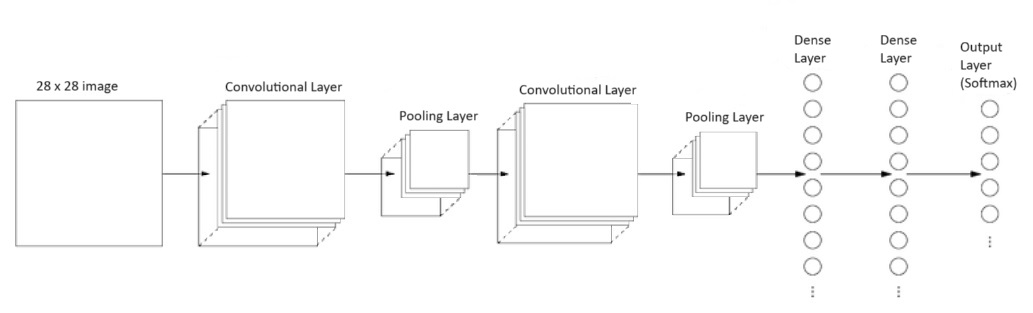

In [10]:
def cnn_model(blocks, filters, kernel_size, pool_size, layers, units, dropout_rate):
    """
    Builds a CNN model.

    Args:
        blocks (int): Number of pairs of convolutional and max pooling layers blocks.
        filters (int): Number of filters for the convolutional layers.
        kernel_size (tuple): Size of the kernel for the convolutional layers.
        pool_size (tuple): Size of the pooling window for the max pooling layers.
        layers (int):  Number of pairs of dense and dropout layers blocks.
        units (int): Number of units in the dense layers.
        dropout_rate (float): Percentage of input to drop at dropout layers.

    Returns:
        model: Constructed CNN model.
    """

    model = models.Sequential()
    
    model.add(Input((28,28,1)))
    
    for _ in range(blocks):
        model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation="relu"))
        model.add(MaxPooling2D(pool_size=pool_size))
    
    model.add(Flatten())

    for _ in range(layers):
        model.add(Dense(units=units, activation="relu"))
        model.add(Dropout(rate=dropout_rate))
    
    model.add(Dense(10, activation="softmax"))

    return model

## Train model

In [11]:
def train_cnn_model(blocks=2, filters=30, kernel_size=(5, 5), pool_size=(2, 2), 
                    layers=2, units=1000, dropout_rate=0.5, learning_rate=1e-3, 
                    epochs=1000, batch_size=32):
    """
    Trains a CNN model.

    Args:
        blocks (int): Number of pairs of convolutional and max pooling layers blocks.
        filters (int): Number of filters for the convolutional layers.
        kernel_size (tuple): Size of the kernel for the convolutional layers.
        pool_size (tuple): Size of the pooling window for the max pooling layers.
        layers (int):  Number of pairs of dense and dropout layers blocks.
        units (int): Number of units in the dense layers.
        dropout_rate (float): Percentage of input to drop at dropout layers.
        learning_rate (float): Learning rate for the Adam optimizer.
        epochs (int): Number of epochs to train the model.
        batch_size (int): Number of samples per batch.

    Returns:
        model: Trained CNN model.
        history: Training history object which includes training and validation metrics.
    """

    # Create model instance
    model = cnn_model(blocks=blocks,
                      filters=filters,
                      kernel_size=kernel_size,
                      pool_size=pool_size,
                      layers=layers,
                      units=units,
                      dropout_rate=dropout_rate)
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='sparse_categorical_crossentropy', metrics=['acc'])

    # Create callback for early stopping on validation loss
    # If the loss does not decrease in patience consecutive tries, stop training
    callbacks = [EarlyStopping(monitor='val_loss', patience=4)]

     # Train model
    history = model.fit(
            norm_train_images,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(norm_val_images, val_labels),
            verbose=2,
            batch_size=batch_size)
    
    # Print results
    print(f"\nValidation accuracy: {history.history['val_acc'][-1]}")
    print(f"Validation loss: {history.history['val_loss'][-1]}")

    return model, history

In [12]:
model, history = train_cnn_model()

Epoch 1/1000
1875/1875 - 58s - 31ms/step - acc: 0.9543 - loss: 0.1468 - val_acc: 0.9840 - val_loss: 0.0500
Epoch 2/1000
1875/1875 - 49s - 26ms/step - acc: 0.9845 - loss: 0.0563 - val_acc: 0.9822 - val_loss: 0.0542
Epoch 3/1000
1875/1875 - 49s - 26ms/step - acc: 0.9875 - loss: 0.0460 - val_acc: 0.9878 - val_loss: 0.0392
Epoch 4/1000
1875/1875 - 52s - 28ms/step - acc: 0.9887 - loss: 0.0388 - val_acc: 0.9828 - val_loss: 0.0569
Epoch 5/1000
1875/1875 - 52s - 28ms/step - acc: 0.9905 - loss: 0.0349 - val_acc: 0.9874 - val_loss: 0.0452
Epoch 6/1000
1875/1875 - 52s - 28ms/step - acc: 0.9917 - loss: 0.0295 - val_acc: 0.9848 - val_loss: 0.0550
Epoch 7/1000
1875/1875 - 49s - 26ms/step - acc: 0.9924 - loss: 0.0281 - val_acc: 0.9884 - val_loss: 0.0531

Validation accuracy: 0.9883999824523926
Validation loss: 0.053146593272686005


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 30)     │           780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 30)       │        22,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │       481,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        10,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545,962 (17.34 MB)

 Trainable params: 1,515,320 (5.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,030,642 (11.56 MB)

## Tune hyperparameters

In [14]:
def plot_history(history):
    """
    Plots the training and validation loss and accuracy over epochs.
    
    Args:
        history: Training history object which includes training and validation metrics.
    """
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Loss')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'], label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_acc'], label = 'Val Accuracy')
    plt.legend()
    plt.show()

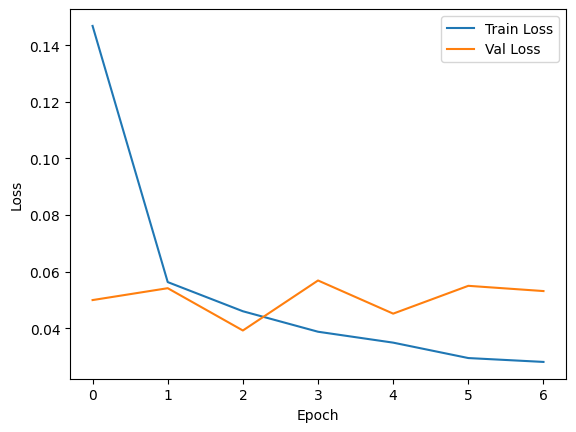

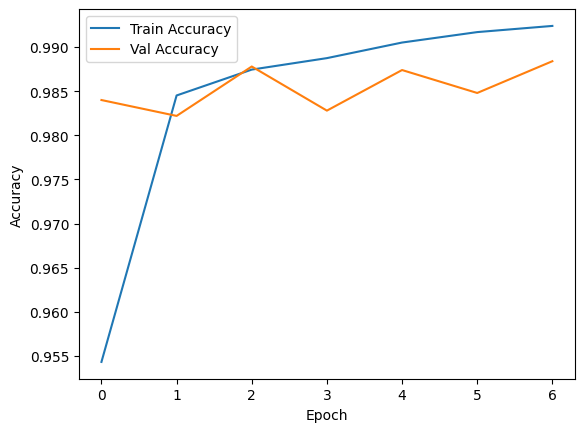

In [15]:
plot_history(history)

## Evaluate model

In [16]:
loss, acc = model.evaluate(norm_test_images, test_labels)
print(f"Model loss: {loss:.2f}")
print(f"Model accuracy: {acc * 100:.2f}%")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.9962 - loss: 0.0170
Model loss: 0.02
Model accuracy: 99.64%


## Save model

In [17]:
model.save('model.keras')

## Make predictions

In [18]:
predictions = model.predict(test_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [19]:
def plot_image(prediction, true_label, img):
    """
    Plots an image along with its predicted label and true label.

    Args:
        prediction (numpy.ndarray): The predicted label probabilities.
        true_label (int): The true label for the image.
        img (numpy.ndarray): The image data.
    """

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction)
    
    plt.xlabel(f"Pred: {predicted_label} ({100*np.max(prediction):.0f}%) Correct: {true_label}")


def plot_bar_chart(prediction, true_label):
    """
    Plots a bar chart showing the predicted label probabilities.

    Args:
        prediction (numpy.ndarray): The predicted label probabilities.
        true_label (int): The true label for the image.
    """

    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), prediction, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(prediction)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

Plot the first X test images, their predicted labels, and the true labels.

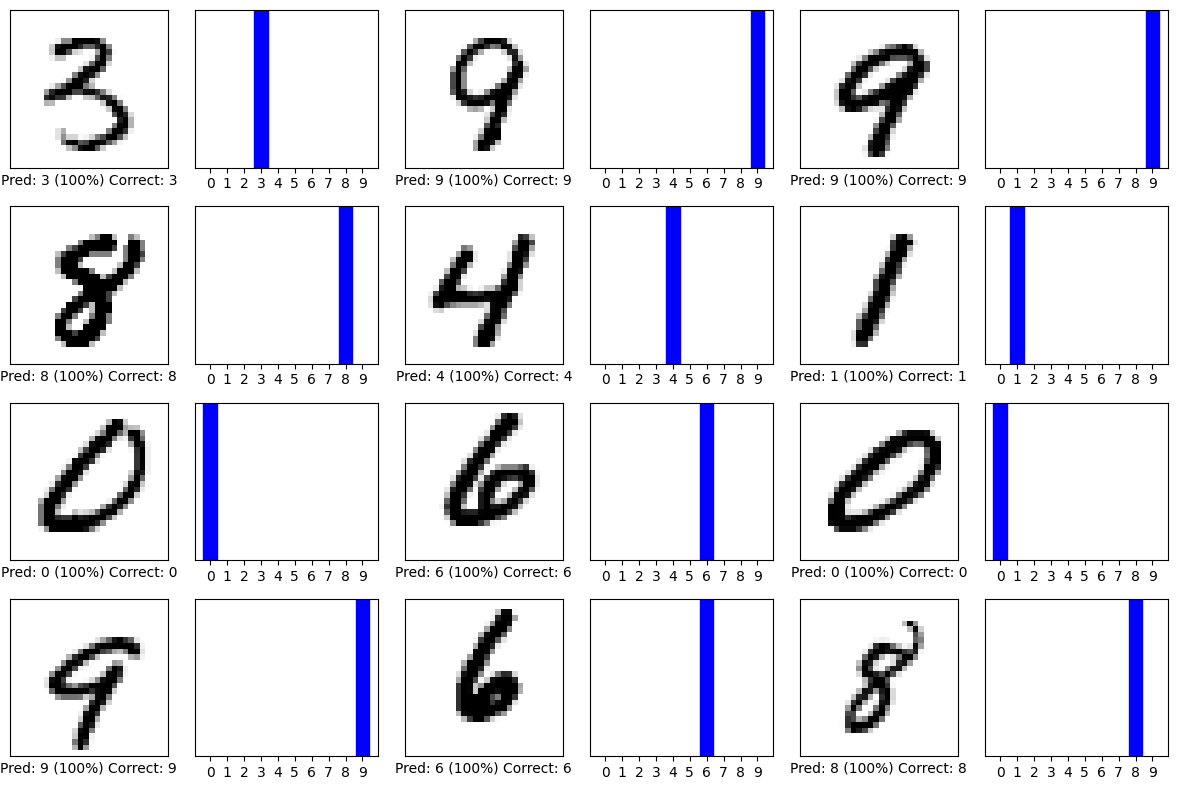

In [20]:
num_rows = 4
num_cols = 3
num_images = num_rows*num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):

    # Left subplot for the image
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(predictions[i], test_labels[i], test_images[i])

    # Right subplot for the prediction plot
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_bar_chart(predictions[i], test_labels[i])

plt.tight_layout()
plt.show()

## Errors

The list errors contains the indexes of the test images that the neural network model could not classify correctly.

In [31]:
errors = []

for i in range(len(predictions)):

    # If prediction is not equal to correct label    
    if np.argmax(predictions[i]) != test_labels[i]:
        
        errors.append(i)

print(f"Failed {len(errors)} out of {len(predictions)} predictions")

Failed 28 out of 5000 predictions


Plot the miss predicted test images, their predicted labels, and the true labels.

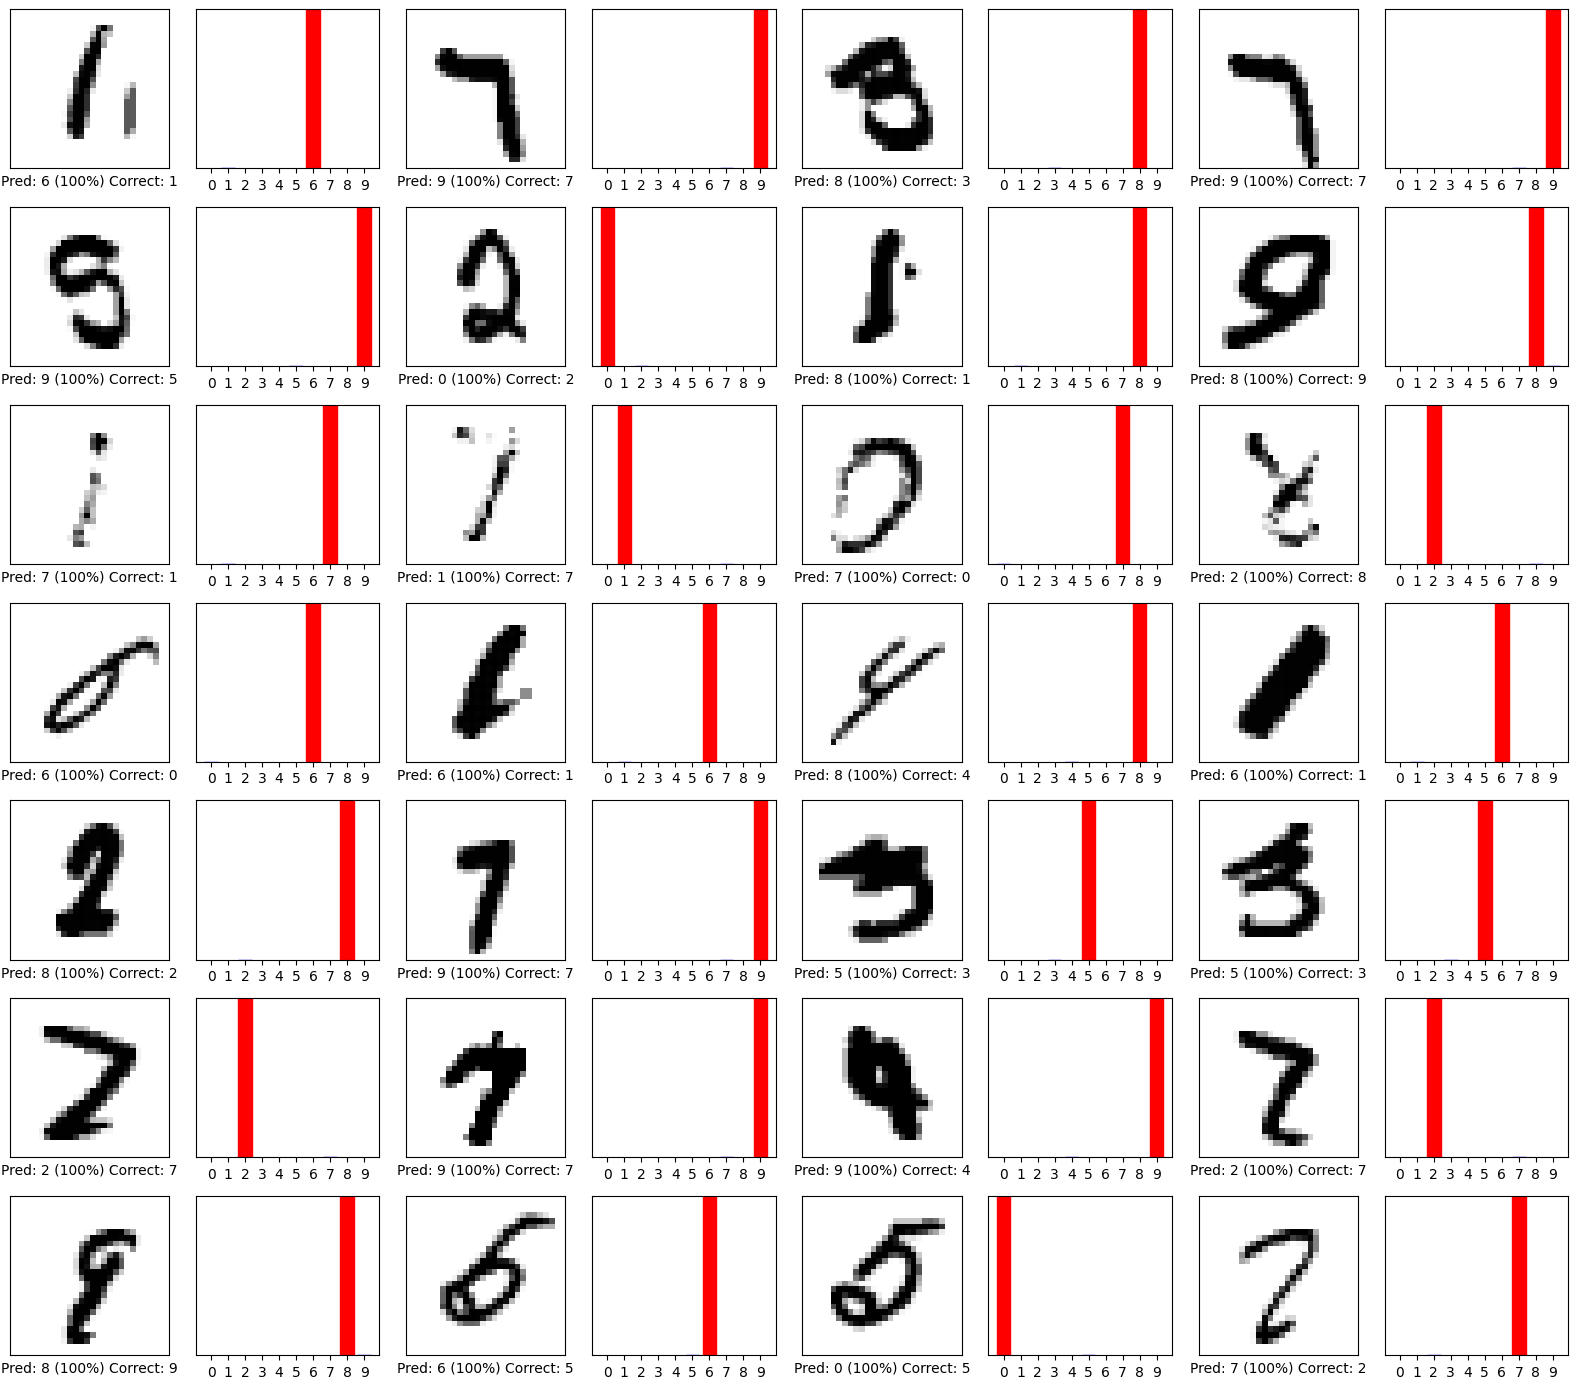

In [33]:
num_cols = 4
num_rows = len(errors) // num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))

# Counter for the subplots
j=0

for i in errors:

    # Left subplot for the image
    plt.subplot(num_rows, 2*num_cols, 2*j+1)
    plot_image(predictions[i], test_labels[i], test_images[i])

    # Right subplot for the prediction plot
    plt.subplot(num_rows, 2*num_cols, 2*j+2)
    plot_bar_chart(predictions[i], test_labels[i])

    j+=1

plt.tight_layout()
plt.show()